# Topic Modeling with BERT

In [1]:
import numpy as np
import pandas as pd

import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    """ Calculate a class-based TF-IDF where m is the number of total documents. """
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

## Load data
For this example, let's use the famous 20Newsgroups dataset which contains roughly 18000 newsgroups posts on 20 topics.

In [3]:
data = fetch_20newsgroups(subset='all')['data']

In [4]:
print(len(data))
data[0]

18846


"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

## Create embeddings
The very first step is converting the documents to numerical data. There are many methods that can be applied, but since we are modeling topics with **BERT** that is what we are going to be using.

There are many pre-trained models that you can use for a large amount of languages [here](https://www.sbert.net/docs/pretrained_models.html). Simply plug-in the name instead of *distilbert-base-nli-mean-tokens*. 

In [5]:
%%time
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)


CPU times: user 51min 35s, sys: 2min 17s, total: 53min 52s
Wall time: 16min 36s


In [6]:
embeddings.shape

(18846, 768)

## Reduce dimensionality
We use **UMAP** to reduce the dimensionality of the embeddings created above. It is important that we keep a little bit of dimensionality as that allows the reduced embeddings to contain more structure to improve clustering at a later stage. 

You can play around with the **number of components** (dimensionality to reduce to) and the **number of neighbors** (the nearby points to look at). 

In [7]:
%%time
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=42).fit_transform(embeddings)

CPU times: user 29.6 s, sys: 1.16 s, total: 30.8 s
Wall time: 28.6 s


In [8]:
umap_embeddings.shape

(18846, 5)

## Cluster documents
Since **UMAP** keeps some of the original high-embedded structure, it makes sense to use **HDBSCAN** to find highly-densed clusters. The metric is euclidean since it does not suffer from high-dimensionality and the **minimum cluster size** allows you to decrease the number of topics found and increase the topic sizes. 

In [9]:
%%time
cluster = hdbscan.HDBSCAN(min_cluster_size=30,
                          metric='euclidean',
                          cluster_selection_method='eom', 
                          prediction_data=True).fit(umap_embeddings)

CPU times: user 607 ms, sys: 83.8 ms, total: 691 ms
Wall time: 1.35 s


In [10]:
cluster

HDBSCAN(min_cluster_size=30, prediction_data=True)

## Visualize Clusters
We can visualize the resulting cluster by embedding the data into **2d-space** using **UMAP** and using matplotlib to color the clusters. Some clusters are difficult to spot as there may be > 50 topics generated. 

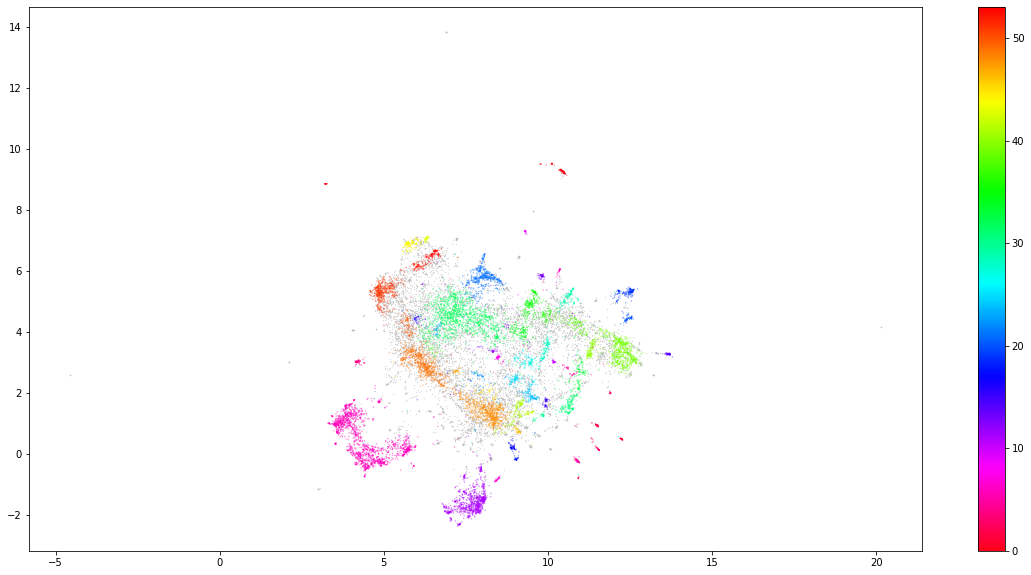

In [11]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
# plt.savefig("result1.png", dpi = 300)

## Prepare results
For easier selection, we put the results in a pandas dataframe. Then, *docs_per_label* is created in which all documents within a single cluster are joined. 

In [12]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [13]:
docs_per_topic

,Topic,Doc
0,-1,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...
1,0,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...
2,1,From: gardner@convex.com (Steve Gardner)\nSubj...
3,2,From: an030@cleveland.Freenet.Edu (Broward Hor...
4,3,From: R1328@vmcms.csuohio.edu\nSubject: Re: CL...
5,4,From: ednclark@kraken.itc.gu.edu.au (Jeffrey C...
6,5,From: walter@uni-koblenz.de (Walter Hower)\nSu...
7,6,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...
8,7,From: djf@cck.coventry.ac.uk (Marvin Batty)\nS...
9,8,From: ricky@watson.ibm.com (Rick Turner)\nSubj...


## Calculate word importance per topic
Calculate the importance of words  in a topic compared to all other topics by considering all documents in a topic to be a single document instead before applying **TF-IDF**. Then, we simply extract the words with the highest values in each cluster as a representative of a topic. 

In [14]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m = len(data), ngram_range=(1, 2))

In [15]:
tf_idf.shape
count

CountVectorizer(ngram_range=(1, 2), stop_words='english')

In [16]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,8139
7,6,1729
33,32,1287
12,11,953
50,49,658
40,39,636
49,48,635
22,21,489
52,51,453
36,35,218


In [17]:
len(top_n_words)
topic_sizes.shape

(55, 2)

In [18]:
top_n_words[0]

[('armenian', 0.014159615413299268),
 ('armenians', 0.014109458355433339),
 ('turkish', 0.012932961537250697),
 ('armenia', 0.009469070347142465),
 ('turks', 0.007164196048661839),
 ('azerbaijan', 0.006973234730190496),
 ('serdar', 0.006826396327841634),
 ('argic', 0.006793688156466202),
 ('serdar argic', 0.006772191418935989),
 ('genocide', 0.006186048822454011),
 ('soviet', 0.006183333397062273),
 ('turkey', 0.0060128828403698325),
 ('zuma', 0.005077969011888158),
 ('zuma uucp', 0.005020617375035345),
 ('sera zuma', 0.004864466893845763),
 ('uucp serdar', 0.004864466893845763),
 ('sera', 0.004859918512637358),
 ('said', 0.004746648015093548),
 ('russian', 0.004567106044352481),
 ('azerbaijani', 0.0045303210391823565)]

## Topic Reduction

In [19]:
for i in tqdm(range(20)):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

100%|██████████| 20/20 [02:10<00:00,  6.53s/it]


,Topic,Size
0,-1,8139
6,5,1729
19,18,1510
7,6,988
29,28,891
25,24,670
30,29,658
12,11,530
32,31,453
22,21,290
